# Introduction & Setup

Protein Structure Prediction is an important task in bioinformatics. Proteins are essential molecules in living organisms, and their function is determined by how they fold into 3D structures. The secondary structure prediction task involves predicting the local structure elements of a protein (such as helices, strands, and loops) based on the amino acid sequence.

Traditionally, these structures are determined using experimental techniques such as X-ray crystallography or NMR, which are expensive and time-consuming. Deep learning models like Convolutional Neural Networks (CNNs) offer a faster, computational approach to predict these secondary structures (sst3 and sst8) from the primary sequences of amino acids.

The goal of this project is to predict two levels of secondary structure from protein sequences:
1. **sst3**: Three-state secondary structure classification (helix, strand, coil).
2. **sst8**: Eight-state secondary structure classification for more granularity.

We will be focusing on CNNs as our deep learning approach to achieve this prediction.


#### Installation and Imports

In [ ]:
pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import time
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import os
import json
import random
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/Neural Networks Project/alfrandom/2018-06-06-pdb-intersect-pisces.csv"
df = pd.read_csv(file_path)

In [ ]:
output_dir = '/content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [ ]:
# Test Set
test_size = 100
test_ix = random.sample(range(df.shape[0]), test_size)
df_test = df.iloc[test_ix].reset_index(drop=True)
df = df.drop(test_ix).reset_index(drop=True)
print(f"Training Set Shape: {df.shape}")
print(f"Test Set Shape: {df_test.shape}")


Training Set Shape: (8978, 11)
Test Set Shape: (100, 11)


# Preprocessing

## Padding & Cropping

In [ ]:
# Preprocessing Functions

def pad_sequence(seq_df, maxlen):
    """Pads sequences with dots and adds delimiters."""
    out = ['<'+i+'>'+'.'*(maxlen-len(i)) for i in seq_df]
    return out

def crop_sequence(seq_long, max_len):
    """Breaks long sequences into subsequences of desired length."""
    # Cracking Sequence
    out_1 = [
        '<' + seq_long[j][i-max_len:i] + '.' if i == 0
        else '.' + seq_long[j][i-max_len:i] + '.'
        for j in seq_long.index
        for i in range(max_len, len(seq_long[j]), max_len)
    ]
    # Extracting and padding the last part of each sequence
    out_2 = [
        seq_long[j][max_len * (len(seq_long[j]) // max_len):]
        for j in seq_long.index
    ]
    out_2 = pad_sequence(out_2, max_len)
    # Unifying both
    out_1.extend(out_2)
    return out_1

def crop_pad_sequences(df, max_len):
    """Pads or crops sequences based on their lengths."""
    # Dividing Dataset
    df_short = df[df['seq'].str.len() < max_len]  # Needs padding
    df_exact = df[df['seq'].str.len() == max_len]  # Exact length
    df_long = df[df['seq'].str.len() > max_len]  # Needs cropping

    # Preparing Features
    seq_short = pad_sequence(df_short['seq'], max_len)
    seq_exact = ['<'+i+'>' for i in df_exact['seq']]
    seq_long = crop_sequence(df_long['seq'], max_len)
    seq_features = [i for l in [seq_short, seq_exact, seq_long] for i in l]  # Concatenation
    print(f'Number of Sequences: {len(seq_features)}')

    # Preparing Q3
    q3_short = pad_sequence(df_short['sst3'], max_len)
    q3_exact = ['<'+i+'>' for i in df_exact['sst3']]
    q3_long = crop_sequence(df_long['sst3'], max_len)
    q3 = [i for l in [q3_short, q3_exact, q3_long] for i in l]
    print(f'Number of Q3 Labels: {len(q3)}')

    # Preparing Q8
    q8_short = pad_sequence(df_short['sst8'], max_len)
    q8_exact = ['<'+i+'>' for i in df_exact['sst8']]
    q8_long = crop_sequence(df_long['sst8'], max_len)
    q8 = [i for l in [q8_short, q8_exact, q8_long] for i in l]
    print(f'Number of Q8 Labels: {len(q8)}')

    # Checking Sequence Lengths
    for label, data_list in zip(['Q8', 'Q3', 'Sequences'], [q8, q3, seq_features]):
        lens = [len(j) for j in data_list]
        incorrect = [j for j in lens if j != max_len+2]
        print(f'{label} without desired length ({max_len+2}): {len(incorrect)}')

    return seq_features, q3, q8


In [ ]:
# Sequence Standardization
max_len = int(np.mean(df['len']))  # Hyperparameter: mean sequence length
print(f'Maximum Sequence Length (mean): {max_len}')

Maximum Sequence Length (mean): 243


## Encoders, Decoders & Vocabs

In [ ]:

# Apply Padding and Cropping
seq_features, q3, q8 = crop_pad_sequences(df, max_len)

# Encoding Functions

def enc_dec_vocab(sequence):
    """Creates encoder and decoder functions along with vocab mappings."""
    seq_vocab = np.unique([j for i in sequence for j in i])  # Vocab Dictionary
    seq_stoi = {str(j): i for i, j in enumerate(seq_vocab)}  # String-to-Index
    seq_itos = {i: str(j) for i, j in enumerate(seq_vocab)}  # Index-to-String
    seq_encoder = lambda s: [seq_stoi[c] for c in s]  # Encoder Function
    seq_decoder = lambda s: [seq_itos[c] for c in s]  # Decoder Function
    print(f'Sequence vocabulary: {seq_vocab} | Vocab Length: {len(seq_vocab)}\n')

    return seq_encoder, seq_decoder, seq_vocab, seq_stoi, seq_itos


Number of Sequences: 13467
Number of Q3 Labels: 13467
Number of Q8 Labels: 13467
Q8 without desired length (245): 0
Q3 without desired length (245): 0
Sequences without desired length (245): 0


The data has been properly processed to contain the same context length

In [ ]:
# Features
seq_encoder , seq_decoder , seq_vocab, seq_stoi, seq_itos = enc_dec_vocab(seq_features)
# Q3
q3_encoder , q3_decoder , q3_vocab, q3_stoi, q3_itos = enc_dec_vocab(q3)
# Q8
q8_encoder , q8_decoder , q8_vocab, q8_stoi, q8_itos = enc_dec_vocab(q8)

Sequence vocabulary: ['*' '.' '<' '>' 'A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q'
 'R' 'S' 'T' 'V' 'W' 'Y'] | Vocab Length: 24

Sequence vocabulary: ['.' '<' '>' 'C' 'E' 'H'] | Vocab Length: 6

Sequence vocabulary: ['.' '<' '>' 'B' 'C' 'E' 'G' 'H' 'I' 'S' 'T'] | Vocab Length: 11



## Data Exploration


Descriptive Statistics for Sequence Lengths:
count    8978.000000
mean      243.076409
std       156.656727
min        20.000000
25%       131.000000
50%       208.000000
75%       323.000000
max      1632.000000
Name: len, dtype: float64


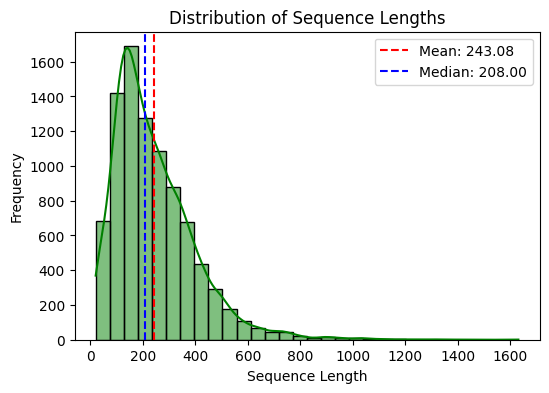

In [ ]:
# Descriptive statistics for sequence lengths
sequence_lengths = df['len']
print("\nDescriptive Statistics for Sequence Lengths:")
print(sequence_lengths.describe())

# Visualizing the distribution with descriptive statistics
plt.figure(figsize=(6, 4))
sns.histplot(sequence_lengths, bins=30, kde=True, color='green')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(sequence_lengths.mean(), color='r', linestyle='--', label=f'Mean: {sequence_lengths.mean():.2f}')
plt.axvline(sequence_lengths.median(), color='b', linestyle='--', label=f'Median: {sequence_lengths.median():.2f}')
plt.legend()
plt.savefig(os.path.join(output_dir, 'distribution_sequence_lengths.png'))
plt.show()



The data is skewed towards the left. The difference between the 3rd quartile & the mode is 1,309 - almost 80% of the data range. As a result, we can experiment with three different preprocessing techniques:
*   Drop out all data with lengths above $\mu + 2\sigma = 556$

*   Cropping & padding all data to 208 (Median), 323 (Q3), 556 ($\mu + 2\sigma$)

*   Keep all data & pad appropriately



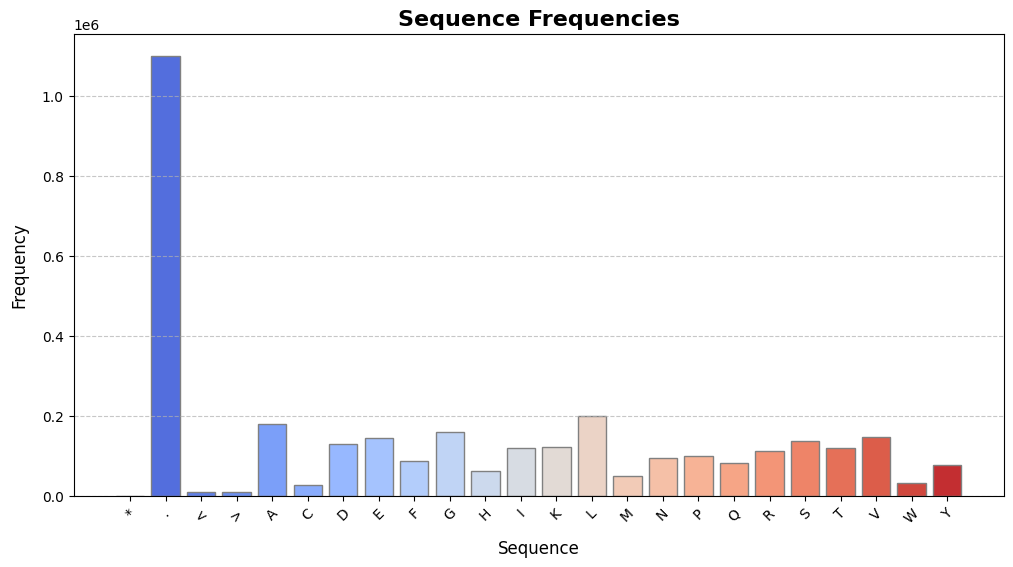

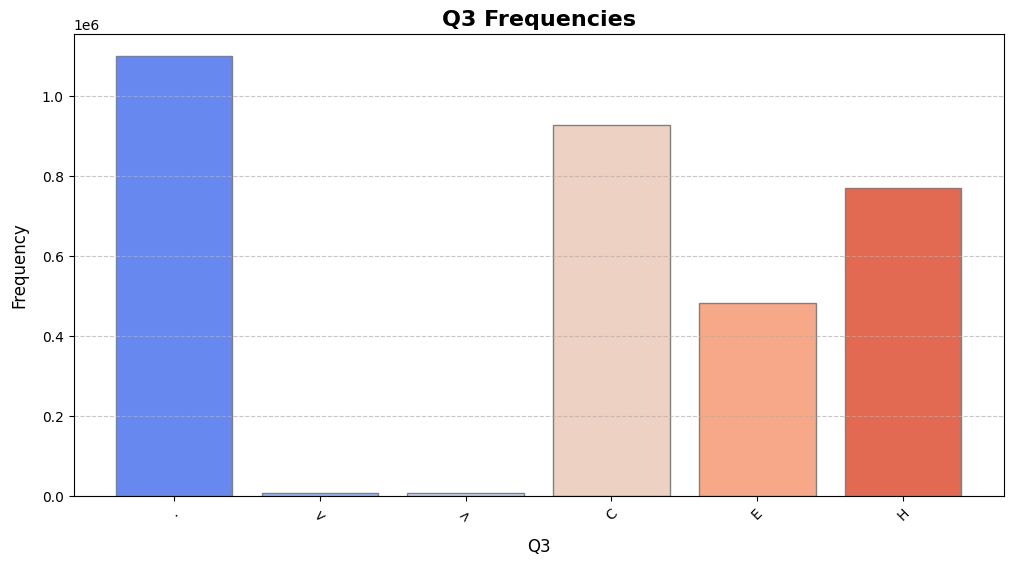

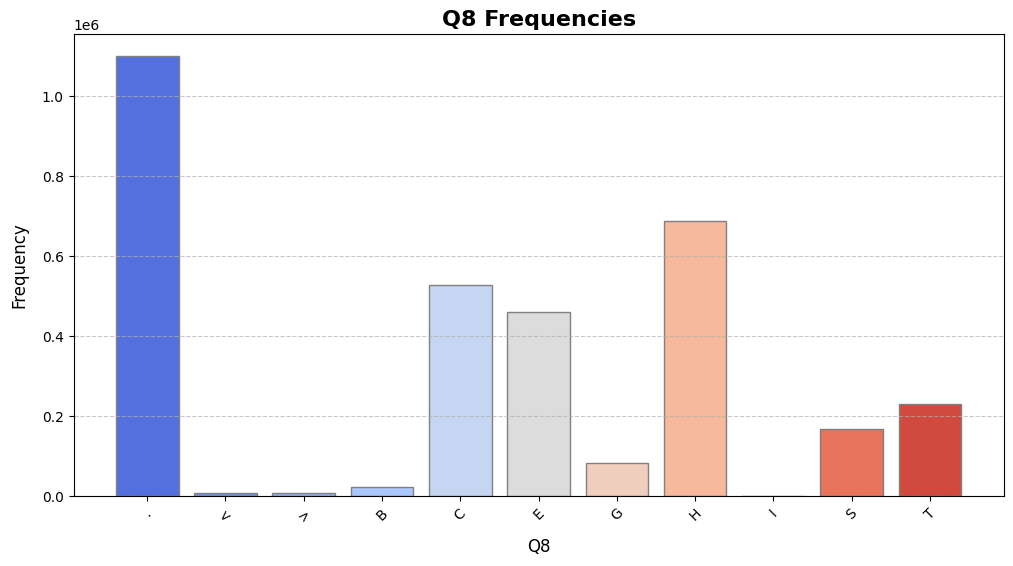

In [ ]:
# Statistics for Class Frequency in Each Data Type (Sequence, Q3 & Q8)

colors_seq = sns.color_palette("coolwarm", len(seq_vocab))
seqs = np.array([seq_encoder(i) for i in seq_features])
seqs_freqs = np.unique(seqs , return_counts  = True)
seq_freqs = {i[0]:i[1] for i in zip(seqs_freqs[0] , seqs_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([seq_itos[i] for i in list(seq_freqs.keys())], seq_freqs.values(), color=colors_seq, edgecolor='grey')
plt.title('Sequence Frequencies', fontsize=16, weight='bold')
plt.xlabel('Sequence', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ticks=list(seq_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'sequence_frequencies.png'))
plt.show()


colors_q3 = sns.color_palette("coolwarm", len(q3_vocab))
q3s = np.array([q3_encoder(i) for i in q3])
q3s_freqs = np.unique(q3s , return_counts  = True)
q3s_freqs = {i[0]:i[1] for i in zip(q3s_freqs[0] , q3s_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([q3_itos[i] for i in list(q3s_freqs.keys())], q3s_freqs.values(), color=colors_q3, edgecolor='grey')
plt.title('Q3 Frequencies', fontsize=16, weight='bold')
plt.xlabel('Q3', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ticks=list(q3s_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'q3_frequencies.png'))
plt.show()



colors_q8 = sns.color_palette("coolwarm", len(q8_vocab))
q8s = np.array([q8_encoder(i) for i in q8])
q8s_freqs = np.unique(q8s , return_counts  = True)
q8s_freqs = {i[0]:i[1] for i in zip(q8s_freqs[0] , q8s_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([q8_itos[i] for i in list(q8s_freqs.keys())], q8s_freqs.values(), color=colors_q8, edgecolor='grey')
plt.title('Q8 Frequencies', fontsize=16, weight='bold')
plt.xlabel('Q8', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ticks=list(q8s_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'q8_frequencies.png'))
plt.show()


There is high class imbalance for Q8 structure I and B. Further analysis is required to determine a more significant imbalance, especially for Q3 and Amino Acids.


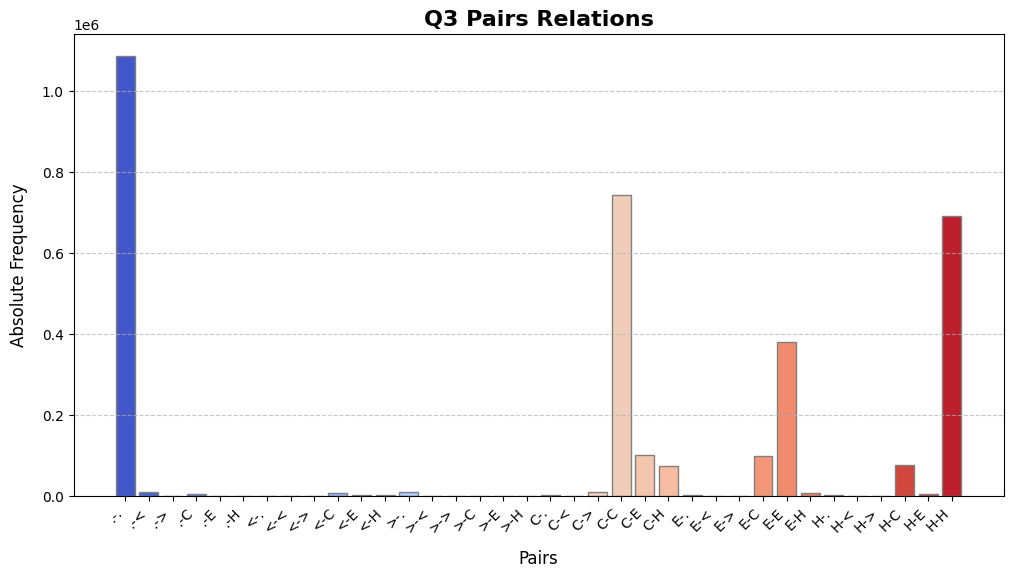

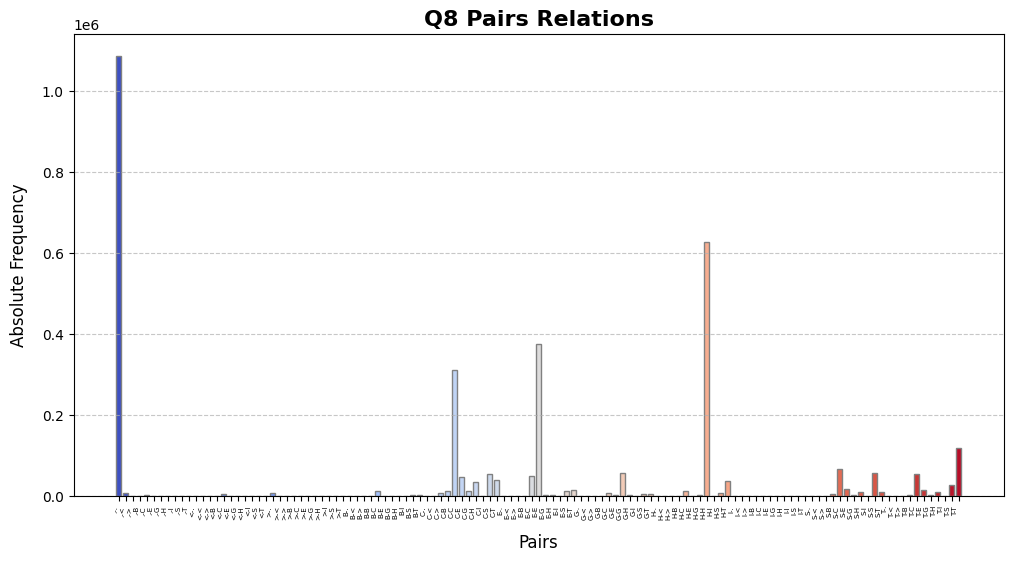

In [ ]:
# Statistics on Bigram Frequencies

q3_pairs = {f"{i1}-{i2}":0 for i1 in list(q3_vocab) for i2 in list(q3_vocab)}
colors_q3_pairs = sns.color_palette("coolwarm", len(q3_pairs))
q3_all = "".join(q3)
for i in zip(q3_all , q3_all[1:]):
  q3_pairs[f"{i[0]}-{i[1]}"] +=1
plt.figure(figsize=(12, 6))
bars = plt.bar(q3_pairs.keys(), q3_pairs.values(), color=colors_q3_pairs, edgecolor='grey')
plt.title("Q3 Pairs Relations", fontsize=16, weight='bold')
plt.xlabel("Pairs", fontsize=12, labelpad=10)
plt.ylabel("Absolute Frequency", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'q3_bigram_frequencies.png'))
plt.show()



q8_pairs = {f"{i1}-{i2}":0 for i1 in list(q8_vocab) for i2 in list(q8_vocab)}
colors_q8_pairs = sns.color_palette("coolwarm", len(q8_pairs))
q8_all = "".join(q8)
for i in zip(q8_all , q8_all[1:]):
  q8_pairs[f"{i[0]}-{i[1]}"] +=1
plt.figure(figsize=(12, 6))
bars = plt.bar(q8_pairs.keys(), q8_pairs.values(), color=colors_q8_pairs, edgecolor='grey')
plt.title("Q8 Pairs Relations", fontsize=16, weight='bold')
plt.xlabel("Pairs", fontsize=12, labelpad=10)
plt.ylabel("Absolute Frequency", fontsize=12, labelpad=10)
plt.xticks(rotation=90, ha='right', fontsize=5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'q8_bigram_frequencies.png'))
plt.show()


The nature of the unbalance seems to be in the way that structures and amino acids pair. In fact, equipairs dominate the distribution.

## Datasets & Dataloaders

In [ ]:
# Torchification: Convert to Tensors
seqs = np.array([seq_encoder(seq) for seq in seq_features])
q3s = np.array([q3_encoder(label) for label in q3])
q8s = np.array([q8_encoder(label) for label in q8])

X = torch.tensor(seqs, dtype=torch.long, device=device)
Y_q3 = torch.tensor(q3s, dtype=torch.long, device=device)
Y_q8 = torch.tensor(q8s, dtype=torch.long, device=device)

data_dict = {'X': X, 'Y_q3': Y_q3, 'Y_q8': Y_q8}
torch.save(data_dict, 'notoken_data_dictionary.pt')
torch.save(data_dict, os.path.join(output_dir, 'notoken_data_dictionary.pt'))

print(f'X shape: {X.shape} | Y_q3 shape: {Y_q3.shape} | Y_q8 shape: {Y_q8.shape}')

X shape: torch.Size([13467, 245]) | Y_q3 shape: torch.Size([13467, 245]) | Y_q8 shape: torch.Size([13467, 245])


In [ ]:
# Custom Dataset & DataLoader

class CustomDataset(Dataset):
    """Custom Dataset for sequence and label tensors."""
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def initialise_loaders(X_train, y_train, X_val, y_val, batch_size):
    """Creates DataLoaders for training and validation datasets."""
    train_dataset = CustomDataset(X=X_train, y=y_train)
    val_dataset = CustomDataset(X=X_val, y=y_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader


# Models

## CNN


In [ ]:
# Hyperparameters
batch_size = 256
context_size = max_len + 2
max_iters = 25  # Number of training epochs
eval_interval = 1  # Evaluate every 'eval_interval' epochs
lr = 3e-3
n_emb = 64
vocab_size = len(seq_vocab)
q3_vocab_size = len(q3_vocab)
q8_vocab_size = len(q8_vocab)
dropout = 0
patience = 5
md = 0.05
fact = 0.1
b1 = 0.9
b2 = 0.999

# CNN-specific hyperparameters
num_filters = 128
kernel_size = 5
num_conv_layers = 3


In [ ]:
# CNN Model Definition

class ProteinCNN(nn.Module):
    def __init__(self, vs, n_emb, num_filters, kernel_size, num_conv_layers, dropout):
        super(ProteinCNN, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_emb, device=device)
        self.dropout = nn.Dropout(dropout)

        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            in_channels = n_emb if i == 0 else num_filters
            self.conv_layers.append(
                nn.Conv1d(in_channels, num_filters, kernel_size, padding=kernel_size // 2)
            )
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(num_filters, vs, device=device)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.token_embedding(x)  # (batch_size, seq_len, n_emb)
        x = x.transpose(1, 2)        # (batch_size, n_emb, seq_len)
        x = self.dropout(x)
        for layer in self.conv_layers:
            x = layer(x)             # (batch_size, num_filters, seq_len)
        x = x.transpose(1, 2)        # (batch_size, seq_len, num_filters)
        logits = self.fc(x)          # (batch_size, seq_len, vs)
        return logits

# Early Stopping Class

class EarlyStopper:
    """Early stops the training if validation F1 doesn't improve after a given patience."""
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def early_stop(self, score):
        if self.best_score is None:
            self.best_score = score
            return False
        elif score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


In [ ]:
# Training Class

class Training:
    def __init__(self, data, model, hyperparams, vocab_dict, verbose=False):
        self.train_loader, self.val_loader = initialise_loaders(
            data['x_train'], data['y_train'],
            data['x_val'], data['y_val'], hyperparams['batch_size']
        )
        self.model = model
        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=hyperparams['lr'], betas=(hyperparams['b1'], hyperparams['b2'])
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience']
        )
        self.hist_loss = {'train': [], 'val': []}
        self.hist_acc = {'train': [], 'val': []}
        self.hist_pres = {'train': [], 'val': []}
        self.hist_f1 = {'train': [], 'val': []}
        self.times = []
        self.hyper = hyperparams
        self.vocab = vocab_dict

        # Retrieve indices for tokens to ignore
        self.padding_index = vocab_dict.get('.', -1)
        self.start_index = vocab_dict.get('<', -1)
        self.end_index = vocab_dict.get('>', -1)
        self.ignore_index = -100
        self.indices_to_ignore = [self.padding_index, self.start_index, self.end_index]

        # Initialize loss function
        self.loss_func = nn.CrossEntropyLoss(ignore_index=self.ignore_index)

        self.early = EarlyStopper(patience=self.hyper['patience'], min_delta=self.hyper['min_delta'])
        self.verbose = verbose

    def __call__(self, *args, **kwargs):
        for epoch in range(self.hyper['epochs']):
            start_time = time.time()
            train_loss = 0
            train_acc = 0
            all_preds = []
            all_targets = []

            # Training Phase
            self.model.train()
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self.model(inputs)
                B, T, C = logits.shape
                logits_flat = logits.view(B * T, C)
                targets_flat = targets.view(B * T)

                # Create mask for valid positions
                mask = torch.ones_like(targets_flat, dtype=torch.bool)
                for idx in self.indices_to_ignore:
                    mask &= (targets_flat != idx)

                # Prepare targets for loss computation
                targets_for_loss = targets_flat.clone()
                targets_for_loss[~mask] = self.ignore_index

                # Compute loss
                loss = self.loss_func(logits_flat, targets_for_loss)
                train_loss += loss.item()

                # Compute accuracy only over valid positions
                preds = torch.argmax(logits_flat, dim=1)
                acc = (preds == targets_flat).float()
                acc = acc[mask].mean()
                train_acc += acc.item()

                # Collect predictions and targets for metric calculations
                all_preds.extend(preds[mask].cpu().numpy())
                all_targets.extend(targets_flat[mask].cpu().numpy())

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Logging Training Metrics
            avg_train_loss = train_loss / len(self.train_loader)
            avg_train_acc = train_acc / len(self.train_loader)
            self.hist_loss['train'].append(avg_train_loss)
            self.hist_acc['train'].append(avg_train_acc)
            self.hist_pres['train'].append(
                precision_score(all_targets, all_preds, average='weighted', zero_division=1)
            )
            self.hist_f1['train'].append(
                f1_score(all_targets, all_preds, average='weighted', zero_division=1)
            )

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.hyper['epochs']} | "
                      f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
                      f"Train Precision: {self.hist_pres['train'][-1]:.4f} | "
                      f"Train F1: {self.hist_f1['train'][-1]:.4f}")

            # Validation Phase
            if (epoch + 1) % self.hyper['eval_int'] == 0:
                val_loss, val_acc, val_precision, val_recall, val_f1 = self.evaluate()

                # Logging Validation Metrics
                self.hist_loss['val'].append(val_loss)
                self.hist_acc['val'].append(val_acc)
                self.hist_pres['val'].append(val_precision)
                self.hist_f1['val'].append(val_f1)

                if self.verbose:
                    print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | "
                          f"Validation Precision: {val_precision:.4f} | Validation F1: {val_f1:.4f}")

                # Early Stopping and Scheduler Step
                if self.early.early_stop(1 / val_f1):
                    if self.verbose:
                        print("Early stopping triggered.")
                    break
                self.scheduler.step(1 / val_f1)

            epoch_time = time.time() - start_time
            self.times.append(epoch_time)

    def evaluate(self):
        """Evaluates the model on the validation set."""
        self.model.eval()
        val_loss = 0
        val_acc = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self.model(inputs)
                B, T, C = logits.shape
                logits_flat = logits.view(B * T, C)
                targets_flat = targets.view(B * T)

                # Create mask for valid positions
                mask = torch.ones_like(targets_flat, dtype=torch.bool)
                for idx in self.indices_to_ignore:
                    mask &= (targets_flat != idx)

                # Prepare targets for loss computation
                targets_for_loss = targets_flat.clone()
                targets_for_loss[~mask] = self.ignore_index

                # Compute loss
                loss = self.loss_func(logits_flat, targets_for_loss)
                val_loss += loss.item()

                # Compute accuracy only over valid positions
                preds = torch.argmax(logits_flat, dim=1)
                acc = (preds == targets_flat).float()
                acc = acc[mask].mean()
                val_acc += acc.item()

                # Collect predictions and targets for metric calculations
                all_preds.extend(preds[mask].cpu().numpy())
                all_targets.extend(targets_flat[mask].cpu().numpy())

        # Calculate average metrics
        average_loss = val_loss / len(self.val_loader)
        average_acc = val_acc / len(self.val_loader)
        average_precision = precision_score(all_targets, all_preds, average='weighted', zero_division=1)
        average_recall = recall_score(all_targets, all_preds, average='weighted', zero_division=1)
        average_f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=1)

        return average_loss, average_acc, average_precision, average_recall, average_f1


In [ ]:
# Plot Learning Curves
def plot_learning_curves(tr, filename_prefix):
    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_loss['train'], label='Training Loss')
    plt.plot(tr.hist_loss['val'], label='Validation Loss')
    plt.title('Learning Curves - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(output_dir, f'{filename_prefix}_learning_curve_loss.png'))
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_acc['train'], label='Training Accuracy')
    plt.plot(tr.hist_acc['val'], label='Validation Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(output_dir, f'{filename_prefix}_learning_curve_accuracy.png'))
    plt.show()


# Plot Confusion Matrix

def plot_confusion_matrix(model, tr, itos, stoi, title='Confusion Matrix', filename=None):
    model.eval()

    # Initialize lists to store all predictions and labels
    all_preds = []
    all_labels = []

    # Retrieve indices for tokens to ignore
    padding_index = stoi.get('.', -1)
    start_index = stoi.get('<', -1)
    end_index = stoi.get('>', -1)
    ignore_index = -100
    indices_to_ignore = [padding_index, start_index, end_index]

    with torch.no_grad():
        for batch, (X_i, y_i) in enumerate(tr.val_loader):
            logits = model(X_i)
            preds = torch.argmax(logits, dim=-1)

            # Flatten predictions and labels
            preds_flat = preds.reshape(-1)
            y_flat = y_i.reshape(-1)

            # Create a mask to exclude unwanted tokens
            mask = torch.ones_like(y_flat, dtype=torch.bool)
            for idx in indices_to_ignore:
                mask &= (y_flat != idx)

            # Apply mask and move tensors to CPU
            preds_flat = preds_flat[mask].cpu()
            y_flat = y_flat[mask].cpu()

            # Append to the lists
            all_preds.append(preds_flat)
            all_labels.append(y_flat)

    # Concatenate all predictions and labels
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)

    # Convert to numpy arrays
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    # Generate confusion matrix
    valid_labels = sorted(set(y_true) | set(y_pred))
    print(f"Valid labels after filtering: {valid_labels}")

    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itos[label] for label in valid_labels],
                yticklabels=[itos[label] for label in valid_labels])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    if filename:
        plt.savefig(os.path.join(output_dir, filename))
    plt.show()


## Initial Predictions

In [ ]:
# Function to Split Data into Training and Validation Sets
def split_data(X, Y, validation_split=0.15):
    """Splits data into training and validation sets."""
    total_samples = X.shape[0]
    val_size = int(total_samples * validation_split)
    indices = torch.randperm(total_samples)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_val = X[val_indices]
    Y_val = Y[val_indices]

    return X_train, Y_train, X_val, Y_val

#### Q3

Q3 Model's trainable parameters: 207494
Epoch 1/25 | Train Loss: 0.9883 | Train Acc: 0.5331 | Train Precision: 0.5313 | Train F1: 0.5122
Validation Loss: 0.8090 | Validation Acc: 0.6421 | Validation Precision: 0.6394 | Validation F1: 0.6375
Epoch 2/25 | Train Loss: 0.7769 | Train Acc: 0.6588 | Train Precision: 0.6564 | Train F1: 0.6548
Validation Loss: 0.7665 | Validation Acc: 0.6637 | Validation Precision: 0.6611 | Validation F1: 0.6613
Epoch 3/25 | Train Loss: 0.7551 | Train Acc: 0.6699 | Train Precision: 0.6676 | Train F1: 0.6665
Validation Loss: 0.7584 | Validation Acc: 0.6687 | Validation Precision: 0.6665 | Validation F1: 0.6647
Epoch 4/25 | Train Loss: 0.7410 | Train Acc: 0.6774 | Train Precision: 0.6751 | Train F1: 0.6742
Validation Loss: 0.7535 | Validation Acc: 0.6700 | Validation Precision: 0.6725 | Validation F1: 0.6664
Epoch 5/25 | Train Loss: 0.7356 | Train Acc: 0.6802 | Train Precision: 0.6782 | Train F1: 0.6772
Validation Loss: 0.7459 | Validation Acc: 0.6748 | Validati

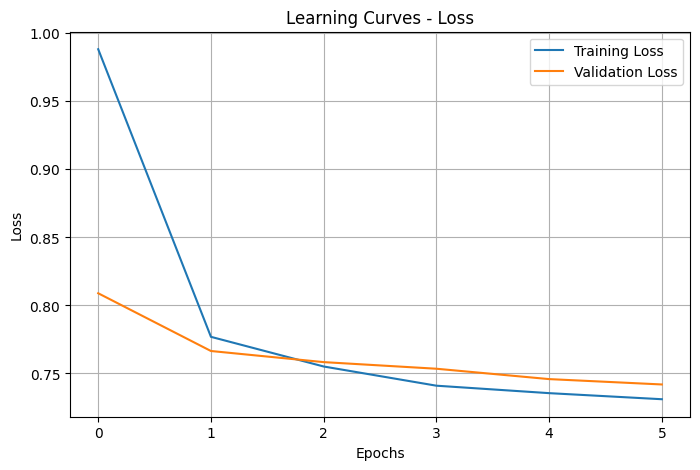

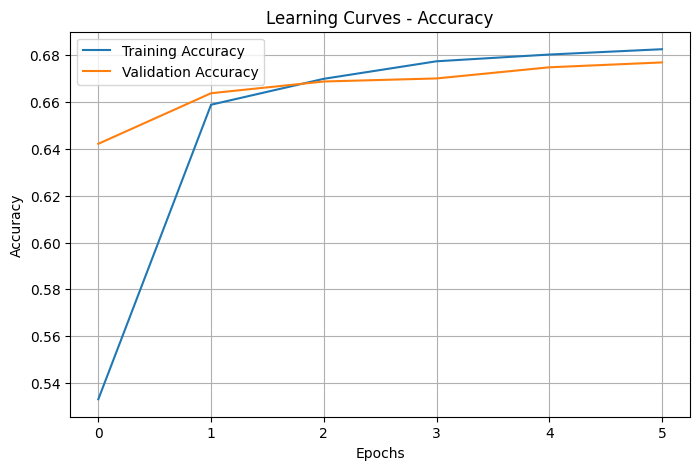

Valid labels after filtering: [3, 4, 5]


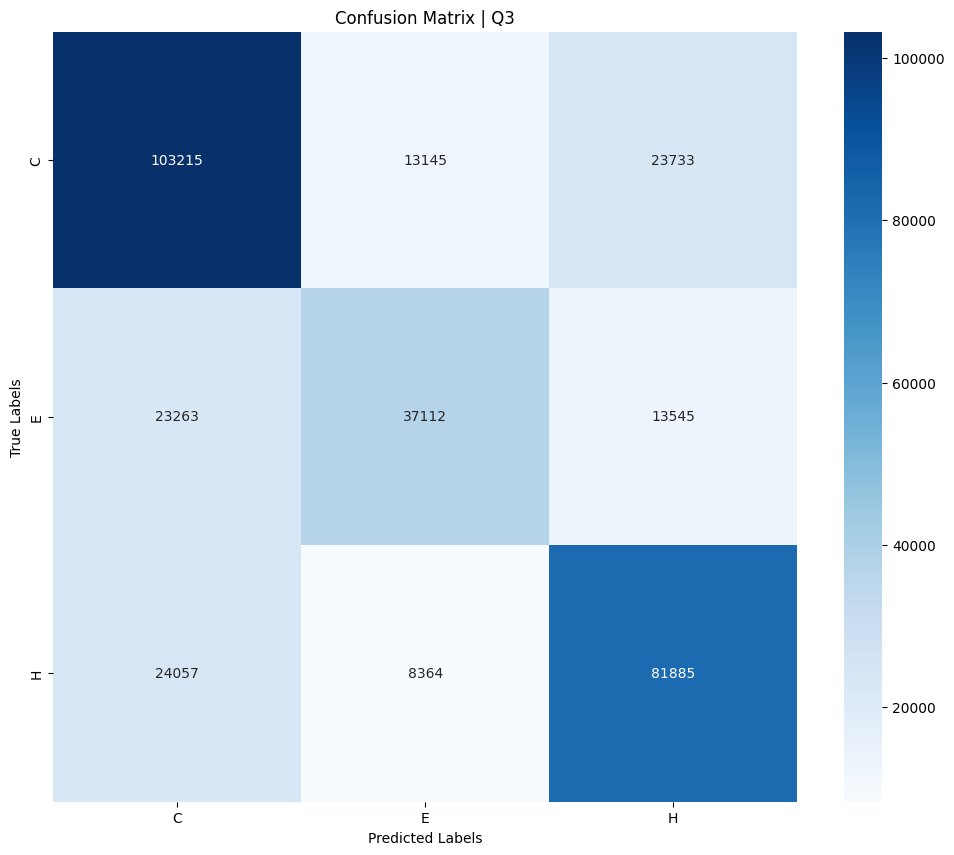

In [ ]:

# Training and Evaluation for Q3

# Splitting Data
x_tr_q3, y_tr_q3, x_val_q3, y_val_q3 = split_data(X, Y_q3, validation_split=0.15)

# Preparing Inputs for Q3
data_q3 = {'x_train': x_tr_q3, 'y_train': y_tr_q3, 'x_val': x_val_q3, 'y_val': y_val_q3}
hyperparams = {
    'batch_size': 256,
    'epochs': 25,
    'lr': 3e-3,
    'eval_int': 1,
    'patience': 5,
    'factor': 0.1,
    'min_delta': 0.05,
    'b1': 0.9,
    'b2': 0.999
}

# Instantiate Model for Q3
pr_q3 = ProteinCNN(q3_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
pr_q3.to(device)
print(f"Q3 Model's trainable parameters: {sum(p.numel() for p in pr_q3.parameters())}")

# Instantiate Training Class for Q3
tr_q3 = Training(data_q3, pr_q3, hyperparams, q3_stoi, verbose=True)

# Train Q3 Model
tr_q3()

# Plot Learning Curves for Q3
plot_learning_curves(tr_q3, filename_prefix='q3_optimized')

# Plot Confusion Matrix for Q3
plot_confusion_matrix(pr_q3, tr_q3, q3_itos, q3_stoi, title='Confusion Matrix | Q3', filename='confusion_matrix_q3.png')



The confusion matrix shows that the model predicts the "C" and "H" classes more accurately than the "E" class, with "C" having the highest correct predictions.

#### Q8

Q8 Model's trainable parameters: 208139
Epoch 1/25 | Train Loss: 1.5063 | Train Acc: 0.4295 | Train Precision: 0.3943 | Train F1: 0.3721
Validation Loss: 1.3143 | Validation Acc: 0.5166 | Validation Precision: 0.5776 | Validation F1: 0.4747
Epoch 2/25 | Train Loss: 1.2771 | Train Acc: 0.5325 | Train Precision: 0.5103 | Train F1: 0.4908
Validation Loss: 1.2670 | Validation Acc: 0.5368 | Validation Precision: 0.5198 | Validation F1: 0.4888
Epoch 3/25 | Train Loss: 1.2464 | Train Acc: 0.5446 | Train Precision: 0.5208 | Train F1: 0.5050
Validation Loss: 1.2334 | Validation Acc: 0.5497 | Validation Precision: 0.5258 | Validation F1: 0.5132
Epoch 4/25 | Train Loss: 1.2261 | Train Acc: 0.5524 | Train Precision: 0.5291 | Train F1: 0.5148
Validation Loss: 1.2288 | Validation Acc: 0.5496 | Validation Precision: 0.5301 | Validation F1: 0.5129
Epoch 5/25 | Train Loss: 1.2135 | Train Acc: 0.5575 | Train Precision: 0.5345 | Train F1: 0.5216
Validation Loss: 1.2236 | Validation Acc: 0.5518 | Validati

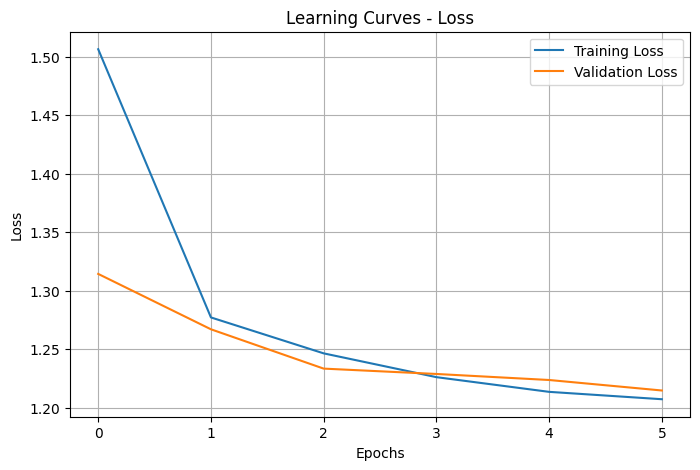

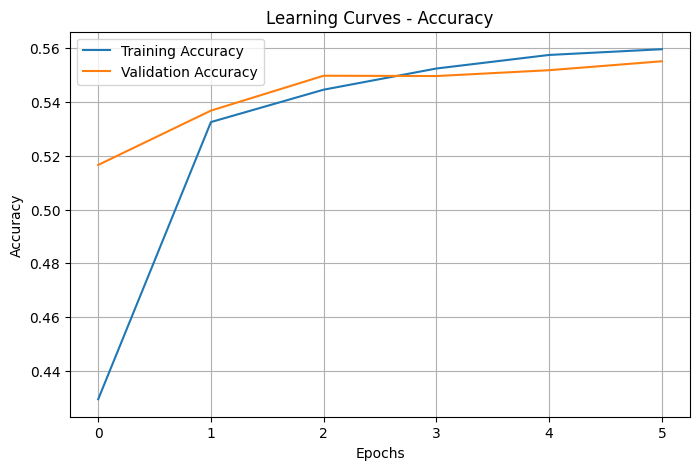

Valid labels after filtering: [3, 4, 5, 6, 7, 8, 9, 10]


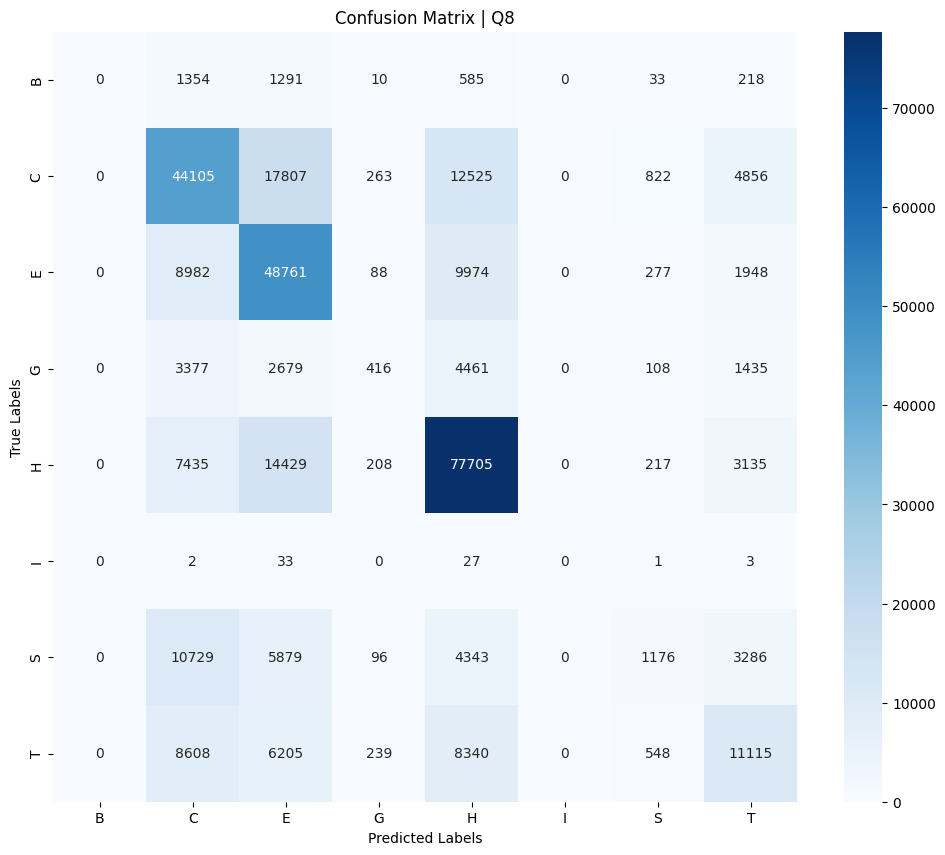

In [ ]:
# Splitting Data
x_tr_q8, y_tr_q8, x_val_q8, y_val_q8 = split_data(X, Y_q8, validation_split=0.15)

# Preparing Inputs for Q8
data_q8 = {'x_train': x_tr_q8, 'y_train': y_tr_q8, 'x_val': x_val_q8, 'y_val': y_val_q8}

# Instantiate Model for Q8
pr_q8 = ProteinCNN(q8_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
pr_q8.to(device)
print(f"Q8 Model's trainable parameters: {sum(p.numel() for p in pr_q8.parameters())}")

# Instantiate Training Class for Q8
tr_q8 = Training(data_q8, pr_q8, hyperparams, q8_stoi, verbose=True)

# Train Q8 Model
tr_q8()

# Plot Learning Curves for Q8
plot_learning_curves(tr_q8, filename_prefix='q8_optimized')

# Plot Confusion Matrix for Q8
plot_confusion_matrix(pr_q8, tr_q8, q8_itos, q8_stoi, title='Confusion Matrix | Q8', filename='confusion_matrix_q8.png')




The confusion matrix for the Q8 structure prediction shows strong performance in classifying the "H" and "E" classes, while other classes, such as "B" and "I," have significantly lower correct predictions and more confusion with other classes.

# Hyperparameter Tuning w/ Bayesian Opt.


In [ ]:
# Apply padding and cropping to the test sequences
seq_test_features, q3_test, q8_test = crop_pad_sequences(df_test, max_len)
# Encode the test sequences and labels
seq_test_encoded = [seq_encoder(seq) for seq in seq_test_features]
q3_test_encoded = [q3_encoder(sst) for sst in q3_test]
q8_test_encoded = [q8_encoder(sst) for sst in q8_test]

# Convert the encoded sequences and labels to tensors
X_test = torch.tensor(seq_test_encoded, dtype=torch.long, device=device)
Y_q3_test = torch.tensor(q3_test_encoded, dtype=torch.long, device=device)
Y_q8_test = torch.tensor(q8_test_encoded, dtype=torch.long, device=device)

# Create Custom Datasets for Q3 and Q8
test_dataset_q3 = CustomDataset(X=X_test, y=Y_q3_test)
test_dataset_q8 = CustomDataset(X=X_test, y=Y_q8_test)

# Create DataLoaders for Q3 and Q8
test_loader_q3 = DataLoader(test_dataset_q3, batch_size=batch_size, shuffle=False)
test_loader_q8 = DataLoader(test_dataset_q8, batch_size=batch_size, shuffle=False)

print(f"Test Set - Q3: {Y_q3_test.shape}, Q8: {Y_q8_test.shape}")


Number of Sequences: 155
Number of Q3 Labels: 155
Number of Q8 Labels: 155
Q8 without desired length (245): 0
Q3 without desired length (245): 0
Sequences without desired length (245): 0
Test Set - Q3: torch.Size([155, 245]), Q8: torch.Size([155, 245])


## Hyperparameter Tunning w/ Bayesian Optmization

In [ ]:
# K-Fold CV Splitting

datasets = {'train': [], 'val': []}
k = KFold(n_splits=3, shuffle=True, random_state=42)
for tr, vl in k.split(np.array([i for i in range(X.shape[0])])):
    tr = torch.tensor(tr, dtype=torch.int, device=device)
    vl = torch.tensor(vl, dtype=torch.int, device=device)
    datasets['train'].append(tr)
    datasets['val'].append(vl)



In [ ]:
# Bayesian Optimization Hyperparameter Bounds

pbounds = {
    'lr': (1e-5, 0.1),
    'batch_size': (32, 256),
    'n_emb': (4, 256),
    'num_filters': (16, 256),
    'kernel_size': (3, 9),
    'num_conv_layers': (1, 5),
    'dropout': (0.0, 0.5),
    'patience': (1, 5),
    'factor': (0.1, 0.5),
    'min_delta': (0.01, 0.1),
    'b1': (0.9, 0.999),
    'b2': (0.95, 0.9999)
}

# Bayesian Optimization Parameters

init_p = 10
n_iter = 5

#### Q3

In [ ]:

def bayes_opt_func(lr, batch_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout, patience, factor, min_delta, b1, b2):
    n_emb = int(n_emb)
    num_filters = int(num_filters)
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel_size is odd
    num_conv_layers = int(num_conv_layers)
    batch_size = int(batch_size)
    patience = int(patience)
    f1s = []
    for i in range(len(datasets['train'])):
        model = ProteinCNN(q3_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
        model.to(device)
        data = {
            'x_train': X[datasets['train'][i], :],
            'y_train': Y_q3[datasets['train'][i], :],
            'x_val': X[datasets['val'][i], :],
            'y_val': Y_q3[datasets['val'][i], :]
        }
        hyperparams = {
            'batch_size': batch_size,
            'epochs': 10,
            'lr': lr,
            'eval_int': eval_interval,
            'patience': patience,
            'factor': factor,
            'min_delta': min_delta,
            'b1': b1,
            'b2': b2
        }
        trainer = Training(data, model, hyperparams, q3_stoi, verbose=False)
        trainer()
        f1s.append(trainer.hist_f1['val'][-1])
    return np.mean(f1s)

In [ ]:
# Bayesian Optimization for Q3

optimizer_q3 = BayesianOptimization(
    f=bayes_opt_func,
    pbounds=pbounds,
    random_state=seed,
)

optimizer_q3.maximize(
    init_points=init_p,
    n_iter=n_iter,
)

|   iter    |  target   |    b1     |    b2     | batch_... |  dropout  |  factor   | kernel... |    lr     | min_delta |   n_emb   | num_co... | num_fi... | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.596     | 0.9764    | 0.951     | 173.9     | 0.3744    | 0.2994    | 4.349     | 0.01981   | 0.07845   | 46.62     | 1.353     | 180.5     | 4.814     |
| 2         | 0.5392    | 0.9004    | 0.9756    | 214.0     | 0.3063    | 0.3887    | 4.751     | 0.09178   | 0.07431   | 140.7     | 1.569     | 105.6     | 3.697     |
| 3         | 0.2537    | 0.9437    | 0.9717    | 170.4     | 0.2566    | 0.3602    | 6.606     | 0.08052   | 0.05695   | 233.0     | 2.277     | 37.71     | 2.203     |
| 4         | 0.6575    | 0.9113    | 0.9914    | 42.5      | 0.3131    | 0.319     | 7.916     | 0.0199    | 0.08712   | 92.62     | 4.019     | 87.0

#### Q8

In [ ]:
def bayes_opt_func_q8(lr, batch_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout, patience, factor, min_delta, b1, b2):
    n_emb = int(n_emb)
    num_filters = int(num_filters)
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel_size is odd
    num_conv_layers = int(num_conv_layers)
    batch_size = int(batch_size)
    patience = int(patience)
    f1s = []
    for i in range(len(datasets['train'])):
        model = ProteinCNN(q8_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
        model.to(device)
        data = {
            'x_train': X[datasets['train'][i], :],
            'y_train': Y_q8[datasets['train'][i], :],
            'x_val': X[datasets['val'][i], :],
            'y_val': Y_q8[datasets['val'][i], :]
        }
        hyperparams = {
            'batch_size': batch_size,
            'epochs': 10,
            'lr': lr,
            'eval_int': eval_interval,
            'patience': patience,
            'factor': factor,
            'min_delta': min_delta,
            'b1': b1,
            'b2': b2
        }
        trainer = Training(data, model, hyperparams, q8_stoi, verbose=False)
        trainer()
        f1s.append(trainer.hist_f1['val'][-1])
    return np.mean(f1s)


In [ ]:
# Bayesian Optimization for Q8

optimizer_q8 = BayesianOptimization(
    f=bayes_opt_func_q8,
    pbounds=pbounds,
    random_state=seed,
)

optimizer_q8.maximize(
    init_points=init_p,
    n_iter=n_iter,
)

|   iter    |  target   |    b1     |    b2     | batch_... |  dropout  |  factor   | kernel... |    lr     | min_delta |   n_emb   | num_co... | num_fi... | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.4305    | 0.9764    | 0.951     | 173.9     | 0.3744    | 0.2994    | 4.349     | 0.01981   | 0.07845   | 46.62     | 1.353     | 180.5     | 4.814     |
| 2         | 0.3455    | 0.9004    | 0.9756    | 214.0     | 0.3063    | 0.3887    | 4.751     | 0.09178   | 0.07431   | 140.7     | 1.569     | 105.6     | 3.697     |
| 3         | 0.1728    | 0.9437    | 0.9717    | 170.4     | 0.2566    | 0.3602    | 6.606     | 0.08052   | 0.05695   | 233.0     | 2.277     | 37.71     | 2.203     |
| 4         | 0.4143    | 0.9113    | 0.9914    | 42.5      | 0.3131    | 0.319     | 7.916     | 0.0199    | 0.08712   | 92.62     | 4.019     | 87.0

In [ ]:
import json

best_params_q3 = optimizer_q3.max['params']

# Define the path to save the best parameters JSON file
params_json_path = '/content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated/optimized_q3_params.json'

# Convert float values to a JSON-compatible format and save
best_params_q3_json = {k: (int(v) if isinstance(v, float) and v.is_integer() else v) for k, v in best_params_q3.items()}

# Save the parameters as a JSON file
with open(params_json_path, 'w') as json_file:
    json.dump(best_params_q3_json, json_file, indent=4)

print(f"Best parameters saved as JSON at {params_json_path}")


Best parameters saved as JSON at /content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated/optimized_q3_params.json


In [ ]:
# Extract and save the best parameters for Q8
best_params_q8 = optimizer_q8.max['params']

# Define the path to save the best parameters JSON file for Q8
params_json_path_q8 = '/content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated/optimized_q8_params.json'

# Convert float values to JSON-compatible format
best_params_q8_json = {k: (int(v) if isinstance(v, float) and v.is_integer() else v) for k, v in best_params_q8.items()}

# Save the Q8 parameters as a JSON file
with open(params_json_path_q8, 'w') as json_file:
    json.dump(best_params_q8_json, json_file, indent=4)

print(f"Best parameters for Q8 saved as JSON at {params_json_path_q8}")


Best parameters for Q8 saved as JSON at /content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated/optimized_q8_params.json


## Model w/ Optimized Hyperparams

#### Q3

In [ ]:
import json

# Load the best parameters for Q3 from the JSON file
params_json_path_q3 = '/content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated/optimized_q3_params.json'
with open(params_json_path_q3, 'r') as json_file:
    best_params_q3 = json.load(json_file)

# Update the `hy` dictionary with the loaded optimized hyperparameters
hy = {
    'batch_size': int(best_params_q3['batch_size']),
    'epochs': 15,  # You can set this to any desired number of epochs
    'lr': best_params_q3['lr'],
    'eval_int': eval_interval,
    'patience': int(best_params_q3['patience']),
    'factor': best_params_q3['factor'],
    'min_delta': best_params_q3['min_delta'],
    'b1': best_params_q3['b1'],
    'b2': best_params_q3['b2']
}

# Instantiate the model using the optimized hyperparameters for model-specific configurations
pr = ProteinCNN(
    q3_vocab_size,
    n_emb=int(best_params_q3['n_emb']),
    num_filters=int(best_params_q3['num_filters']),
    kernel_size=int(best_params_q3['kernel_size']),
    num_conv_layers=int(best_params_q3['num_conv_layers']),
    dropout=best_params_q3['dropout']
)

# Move the model to the specified device
pr.to(device)
print(f"Model's trainable parameters: {sum(p.numel() for p in pr.parameters())}")

# Prepare the input data
data = {'x_train': X, 'y_train': Y_q3, 'x_val': X, 'y_val': Y_q3}

# Initialize and run the training loop
tr = Training(data, pr, hy, q3_stoi, verbose=True)
tr()

# Save the trained model to Google Drive
torch.save(pr.state_dict(), os.path.join(output_dir, 'Q3_protein_cnn_no_token_optimized.pth'))
print("Model saved successfully with optimized hyperparameters.")


Model's trainable parameters: 218061
Epoch 1/15 | Train Loss: 1.0718 | Train Acc: 0.5567 | Train Precision: 0.5647 | Train F1: 0.5338
Validation Loss: 0.8164 | Validation Acc: 0.6473 | Validation Precision: 0.6853 | Validation F1: 0.6181
Epoch 2/15 | Train Loss: 0.8510 | Train Acc: 0.6300 | Train Precision: 0.6322 | Train F1: 0.6194
Validation Loss: 0.7791 | Validation Acc: 0.6686 | Validation Precision: 0.6741 | Validation F1: 0.6401
Epoch 3/15 | Train Loss: 0.8469 | Train Acc: 0.6350 | Train Precision: 0.6336 | Train F1: 0.6260
Validation Loss: 0.7852 | Validation Acc: 0.6713 | Validation Precision: 0.6782 | Validation F1: 0.6482
Epoch 4/15 | Train Loss: 0.8413 | Train Acc: 0.6383 | Train Precision: 0.6364 | Train F1: 0.6297
Validation Loss: 0.7715 | Validation Acc: 0.6802 | Validation Precision: 0.6714 | Validation F1: 0.6689
Epoch 5/15 | Train Loss: 0.8415 | Train Acc: 0.6382 | Train Precision: 0.6361 | Train F1: 0.6298
Validation Loss: 0.8065 | Validation Acc: 0.6787 | Validation 

In [ ]:
from IPython.display import display, HTML

# Load the saved weights for Q3
state_dict_path_q3 = os.path.join(output_dir, 'Q3_protein_cnn_no_token_optimized.pth')
state_dict_q3 = torch.load(state_dict_path_q3, weights_only=True)
pr.load_state_dict(state_dict_q3, strict=True)
pr.eval()
print("Q3 Model loaded successfully.")

print(q3_stoi, '\n\n')
count = 0
acc_total = 0
errors = []

def predict_sequence(model, seq, seq_encoder, decoder, stoi, max_len):
    # Preprocess the sequence
    seq = seq.strip()
    seq_padded = f"<{seq[:max_len]}>"
    if len(seq) < max_len:
        seq_padded += '.' * (max_len - len(seq))

    encoded_seq = seq_encoder(seq_padded)
    input_tensor = torch.tensor(encoded_seq, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    indices_to_ignore = [stoi.get('.', -1), stoi.get('<', -1), stoi.get('>', -1)]
    valid_positions = [i for i, idx in enumerate(encoded_seq) if idx not in indices_to_ignore]
    preds_valid = preds[valid_positions]
    decoded_preds = decoder(preds_valid)
    return ''.join(decoded_preds)

for i in range(df_test.shape[0]):
    count += 1
    seq = df_test['seq'][i]
    ground_truth = df_test['sst3'][i]
    pred = predict_sequence(pr, seq, seq_encoder, q3_decoder, q3_stoi, max_len)
    pred = pred[:len(ground_truth)]

    # Calculate accuracy and record errors
    acc = [1 if p == g else 0 for p, g in zip(pred, ground_truth)]
    acc_perc = sum(acc) / len(acc)
    acc_total += acc_perc

    if acc_perc < 1:  # Save errors for display
        errors.append((seq, ground_truth, pred))

# Display errors with HTML highlighting
for seq, true_seq, pred_seq in errors[:10]:  # limit to 10 examples
    true_label_str = ''.join(true_seq)
    pred_label_str = ''
    for t, p in zip(true_seq, pred_seq):
        pred_label_str += f"<span style='color:red;'>{p}</span>" if t != p else p

    display(HTML(f"<strong>Sequence:</strong> {seq}"))
    display(HTML(f"<strong>True Label:</strong> {true_label_str}<br><strong>Predicted Label:</strong> {pred_label_str}"))
    display(HTML('<hr>'))

print(f'Average Accuracy for Q3: {acc_total / count}')


Q3 Model loaded successfully.
{'.': 0, '<': 1, '>': 2, 'C': 3, 'E': 4, 'H': 5} 




Average Accuracy for Q3: 0.6702107067983729



The Q3 model achieves an average accuracy of approximately 67%, with predictions showing reasonable alignment with true labels, particularly in continuous "C" and "H" regions, but struggles in distinguishing some segments accurately, as indicated by deviations in longer sequences and certain classes (like "E"), which exhibit more inconsistencies between true and predicted labels.

#### Q8

In [ ]:
import json
import os
import torch

# Load the best parameters for Q8 from the JSON file
params_json_path_q8 = '/content/drive/My Drive/Neural Networks Project/CNN_NoToken_Updated/optimized_q8_params.json'
with open(params_json_path_q8, 'r') as json_file:
    best_params_q8 = json.load(json_file)

# Update the `hy` dictionary with the loaded optimized hyperparameters for Q8
hy = {
    'batch_size': int(best_params_q8['batch_size']),
    'epochs': 15,  # Set to the desired number of epochs
    'lr': best_params_q8['lr'],
    'eval_int': eval_interval,
    'patience': int(best_params_q8['patience']),
    'factor': best_params_q8['factor'],
    'min_delta': best_params_q8['min_delta'],
    'b1': best_params_q8['b1'],
    'b2': best_params_q8['b2']
}

# Instantiate the model using the optimized hyperparameters for Q8 model-specific configurations
pr = ProteinCNN(
    q8_vocab_size,
    n_emb=int(best_params_q8['n_emb']),
    num_filters=int(best_params_q8['num_filters']),
    kernel_size=int(best_params_q8['kernel_size']),
    num_conv_layers=int(best_params_q8['num_conv_layers']),
    dropout=best_params_q8['dropout']
)

# Move the model to the specified device
pr.to(device)
print(f"Model's trainable parameters: {sum(p.numel() for p in pr.parameters())}")

# Prepare the input data for Q8
data = {'x_train': X, 'y_train': Y_q8, 'x_val': X, 'y_val': Y_q8}

# Initialize and run the training loop
tr = Training(data, pr, hy, q8_stoi, verbose=True)
tr()

# Save the trained model to Google Drive
torch.save(pr.state_dict(), os.path.join(output_dir, 'Q8_protein_cnn_no_token_optimized.pth'))
print("Model saved successfully with optimized hyperparameters for Q8.")


Model's trainable parameters: 22724
Epoch 1/15 | Train Loss: 1.6676 | Train Acc: 0.3359 | Train Precision: 0.2624 | Train F1: 0.2546
Validation Loss: 1.4784 | Validation Acc: 0.4885 | Validation Precision: 0.6207 | Validation F1: 0.4049
Epoch 2/15 | Train Loss: 1.4626 | Train Acc: 0.4652 | Train Precision: 0.4600 | Train F1: 0.4052
Validation Loss: 1.2971 | Validation Acc: 0.5331 | Validation Precision: 0.6342 | Validation F1: 0.4490
Epoch 3/15 | Train Loss: 1.3993 | Train Acc: 0.4935 | Train Precision: 0.5452 | Train F1: 0.4297
Validation Loss: 1.2801 | Validation Acc: 0.5405 | Validation Precision: 0.5993 | Validation F1: 0.4598
Early stopping triggered.
Model saved successfully with optimized hyperparameters for Q8.


In [ ]:
# Load the saved weights for Q8
state_dict_path_q8 = os.path.join(output_dir, 'Q8_protein_cnn_no_token_optimized.pth')
state_dict_q8 = torch.load(state_dict_path_q8, weights_only=True)
pr.load_state_dict(state_dict_q8, strict=True)
pr.eval()
print("Q8 Model loaded successfully.")

print(q8_stoi, '\n\n')
count = 0
acc_total = 0
errors = []

def predict_sequence(model, seq, seq_encoder, decoder, stoi, max_len):
    seq = seq.strip()
    seq_padded = f"<{seq[:max_len]}>"
    if len(seq) < max_len:
        seq_padded += '.' * (max_len - len(seq))

    encoded_seq = seq_encoder(seq_padded)
    input_tensor = torch.tensor(encoded_seq, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    indices_to_ignore = [stoi.get('.', -1), stoi.get('<', -1), stoi.get('>', -1)]
    valid_positions = [i for i, idx in enumerate(encoded_seq) if idx not in indices_to_ignore]
    preds_valid = preds[valid_positions]
    decoded_preds = decoder(preds_valid)
    return ''.join(decoded_preds)

for i in range(df_test.shape[0]):
    count += 1
    seq = df_test['seq'][i]
    ground_truth = df_test['sst8'][i]
    pred = predict_sequence(pr, seq, seq_encoder, q8_decoder, q8_stoi, max_len)
    pred = pred[:len(ground_truth)]

    # Calculate accuracy and record errors
    acc = [1 if p == g else 0 for p, g in zip(pred, ground_truth)]
    acc_perc = sum(acc) / len(acc)
    acc_total += acc_perc

    if acc_perc < 1:  # Save errors for display
        errors.append((seq, ground_truth, pred))

# Display errors with HTML highlighting
for seq, true_seq, pred_seq in errors[:10]:  # limit to 10 examples
    true_label_str = ''.join(true_seq)
    pred_label_str = ''
    for t, p in zip(true_seq, pred_seq):
        pred_label_str += f"<span style='color:red;'>{p}</span>" if t != p else p

    display(HTML(f"<strong>Sequence:</strong> {seq}"))
    display(HTML(f"<strong>True Label:</strong> {true_label_str}<br><strong>Predicted Label:</strong> {pred_label_str}"))
    display(HTML('<hr>'))

print(f'Average Accuracy for Q8: {acc_total / count}')


Q8 Model loaded successfully.
{'.': 0, '<': 1, '>': 2, 'B': 3, 'C': 4, 'E': 5, 'G': 6, 'H': 7, 'I': 8, 'S': 9, 'T': 10} 




Average Accuracy for Q8: 0.5380426823214928
